In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv1D, Flatten, Reshape, Dense, Dropout, Bidirectional, TimeDistributed, Attention
)
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2025-04-19 22:10:18.921785: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
# load data
test = pd.read_csv('test_secondary_structure_cb513.csv')
train = pd.read_csv('training_secondary_structure_train.csv')
valid = pd.read_csv('validation_secondary_structure_valid.csv')

combined = pd.concat([test, train, valid], ignore_index=True)

combined.to_csv('combined_csv_file.csv', index=False)
train_df, temp_df = train_test_split(combined, test_size=0.2, random_state=42)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

display(train_df.head())
display(valid_df.head())
display(test_df.head())
print(f"train set: {train_df.shape[0]}")
print(f"valid set: {valid_df.shape[0]}")
print(f"test set: {test_df.shape[0]}")


,seq,sst3,sst8
10590,SEDDGSASPESQEMSYTELPCPSICPLIYAPVCVEDSNQDFYLFVN...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCEEEEECCCCEEEECC...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCEEEEETTSCEEEESS...
6909,SIEWHKFETSEEIISTYLLDDVLYTGVNGAVYTFSNNKLNKTGLTN...,CCEEEECCCCCCCCEEEEECCEEEEECECEEEEEECCEEEEEECCC...,CCEEEECSSCCCCCEEEEETTEEEEECBSEEEEEETTEEEEEECCS...
3541,MKHHHHHHSAGLEVLFQGPDSMYVLQDPIWLLMANTDDSIMMTYQL...,CCCCCCCCCCCCCEEEECCCCCEEEECCHHHHCCCCCHHHHHHCCC...,CCCCCCCCCCCCCEEEECSTTCEEEECCHHHHTSCCCHHHHHHCCC...
167,AACKCDDEGPDIRTAPLTGTVDLGSCNAGWEKCASYYTIIADCCRKKK,CEEECCCCCCCCCCCCEEEEEEECCCCCCEEEEEEEEECCEEEEEECC,CEEECSSCCSCCSSSSEEEEEEESSCCTTEEEEEEEEETTEEEEEECC
1915,GAMAQVPTDPGYFSVLLDVKHFSPEEISVKVVGDHVEVHARHEERP...,CCCCCCCCCCCCEEEEEECCCCCHHHEEEEEECCEEEEEEEEEECC...,CCCCCCCCCSSCEEEEEECTTSCGGGEEEEEETTEEEEEEEEEECS...


,seq,sst3,sst8
8167,GXTDTNLVEXRAIERXXFDYSYHLDXNHPEELAALFVEDCEVSYAP...,CCHHHHHHHHHHHHHHHHHHHHHHHCCCHHHHHCCEEEEEEEEEEC...,CCHHHHHHHHHHHHHHHHHHHHHHHTTCHHHHHTTEEEEEEEEEET...
4955,GPGSDLQSILATMNVPAGPAGGQQVDLASVLTPEIMAPILANADVQ...,CCCCCCCCCCCCCCCCCCCCCCCCCCHHHHCCCHHHHHHHCCHHHH...,CCCCCCCCCCCCCCCCCCCCCCCCCCHHHHSCSGGGHHHHTSHHHH...
11039,REFPPPNPDPKFESKAALLAARGPEELLCFTERLEDLVCFWEEAAS...,CCCCCCCCCHHHHHHHHHHHHHCCCCCEEEECCCCCCEEEEEECCC...,CCCCCCCCCHHHHHHHHHHHHHSCSSCEEEBSSSSCCEEEEEECCC...
3532,GSSGSSGMTATAQQLEYLKNSIKSIQDYPKPGILFRDVTSLLEDPK...,CCCCCCCCCCCHHHHHHHHHHCEEECCCCCCCCCEEECHHHHHCHH...,CCCCCCCCCCCHHHHHHHHHHSEEETTCSSTTCCEEETHHHHHCHH...
567,GPGGAERPTLPIPDLLTTDARNRIQLTIGAGQSTFGGKTATTWGYN...,CCCCCCCCECCCCCEECCCCCCEEEEEEEEEEEEECCEEEEEEEEC...,CCCCCCCCBCCCCCEECCCTTSEEEEEEEEEEEEETTEEEEEEEES...


,seq,sst3,sst8
7283,GXSNIYDSANELSRGLRGLPEYKAVKAAKDAIAADAEASKIFTDYL...,CHHHHHHHHHHHHHHHHHCHHHHHHHHHHHHHHHCHHHHHHHHHHH...,CHHHHHHHHHHHHHHHHHCHHHHHHHHHHHHHHHCHHHHHHHHHHH...
6466,MSSLLDIIYQLRQVPRWDGSFQFEKEDVSQHSFSVIAISHILCELK...,CCCHHHHHHHHHHCECCCCCCCCCCCEHHHHHHHHHHHHHHHHHHH...,CCCHHHHHHHGGGCBSSTTSCCSSCCBHHHHHHHHHHHHHHHHHHH...
1791,MILLEVNNRIIEETLALKFENAAAGNKPEAVEVTFADFDGVLYHIS...,CCCCCCCCHHHHHHHHHHHHHHHHCCCCCCCEEEEEECCCEEEEEE...,CCSCCSSCHHHHHHHHHHHHHHHHTCCCCCCEEEEEETTTEEEEEE...
5099,MTMIIRKYFSGIPTIGVLALTTEEITLLPIFLDKDDVNEVSEVLET...,CCCEEEECECCECCHHHHCEECCCEEEECCCCCHHHHHHHHHHHCC...,CCCEEEECBTTBCCHHHHCEECSSEEEECTTCCHHHHHHHHHHHTC...
8471,MAHHHHHHMGTLEAQTQGPGSMTDLQNWTPRPKPERKIFEGRYVRL...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCEECCCEEE...,CCCCCCCCCCCCCCCCCCCCCCCCCTTCCCCCCCCCCCEECSSEEE...


train set: 9088
valid set: 1136
test set: 1137


In [3]:
sst8_to_sst3 = {
    'H': 'H', 'G': 'H', 'I': 'H',
    'E': 'E', 'B': 'E',
    'T': 'C', 'S': 'C', 'C': 'C'
}

def map_sst8_to_sst3(sst8):
    return ''.join([sst8_to_sst3.get(char, 'C') for char in sst8])

train_df['sst3_mapped'] = train_df['sst8'].apply(map_sst8_to_sst3)
valid_df['sst3_mapped'] = valid_df['sst8'].apply(map_sst8_to_sst3)
test_df['sst3_mapped'] = test_df['sst8'].apply(map_sst8_to_sst3)

display(train_df[['sst8', 'sst3_mapped']].head())

,sst8,sst3_mapped
10590,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCEEEEETTSCEEEESS...,CCCCCCCCCCCCCCCCCCCCCCCCCCCCCCCEEEEECCCCEEEECC...
6909,CCEEEECSSCCCCCEEEEETTEEEEECBSEEEEEETTEEEEEECCS...,CCEEEECCCCCCCCEEEEECCEEEEECECEEEEEECCEEEEEECCC...
3541,CCCCCCCCCCCCCEEEECSTTCEEEECCHHHHTSCCCHHHHHHCCC...,CCCCCCCCCCCCCEEEECCCCCEEEECCHHHHCCCCCHHHHHHCCC...
167,CEEECSSCCSCCSSSSEEEEEEESSCCTTEEEEEEEEETTEEEEEECC,CEEECCCCCCCCCCCCEEEEEEECCCCCCEEEEEEEEECCEEEEEECC
1915,CCCCCCCCCSSCEEEEEECTTSCGGGEEEEEETTEEEEEEEEEECS...,CCCCCCCCCCCCEEEEEECCCCCHHHEEEEEECCEEEEEEEEEECC...


In [4]:
def one_hot_encode_sequences(sequences, max_len=None):
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    aa_to_int = {aa: idx for idx, aa in enumerate(amino_acids)}
    aa_to_int['X'] = len(amino_acids)  
    
    integer_encoded = []
    for seq in sequences:
        encoded = [aa_to_int.get(aa, len(amino_acids)) for aa in seq]
        integer_encoded.append(encoded)
    
    if not max_len:
        max_len = max(len(seq) for seq in integer_encoded)
    
    padded_encoded = tf.keras.preprocessing.sequence.pad_sequences(
        integer_encoded, maxlen=max_len, padding='post', truncating='post', value=len(amino_acids)
    )
    
    one_hot_encoded = to_categorical(padded_encoded, num_classes=len(amino_acids)+1)
    
    return one_hot_encoded, max_len

X_train, max_len = one_hot_encode_sequences(train_df['seq'])

X_valid, _ = one_hot_encode_sequences(valid_df['seq'], max_len)

X_test, _ = one_hot_encode_sequences(test_df['seq'], max_len)

display(X_train[0])
display(X_valid[0])

print(f"train one-hot shape: {X_train.shape}")
print(f"valid one-hot shape: {X_valid.shape}")
print(f"test one-hot shape: {X_test.shape}")

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

train one-hot shape: (9088, 1632, 21)
valid one-hot shape: (1136, 1632, 21)
test one-hot shape: (1137, 1632, 21)


In [5]:
def one_hot_encode_labels(labels, max_len):
    sec_structs = ['H', 'E', 'C']
    struct_to_int = {s: idx for idx, s in enumerate(sec_structs)}
    
    integer_encoded = []
    for lbl in labels:
        encoded = [struct_to_int.get(s, 2) for s in lbl]  
        integer_encoded.append(encoded)
    
    padded_encoded = tf.keras.preprocessing.sequence.pad_sequences(
        integer_encoded, maxlen=max_len, padding='post', truncating='post', value=2
    )
    
    y = to_categorical(padded_encoded, num_classes=len(sec_structs))
    
    return y


y_train = one_hot_encode_labels(train_df['sst3_mapped'], max_len)

y_valid = one_hot_encode_labels(valid_df['sst3_mapped'], max_len)

y_test = one_hot_encode_labels(test_df['sst3_mapped'], max_len)

display(y_train[0])
display(y_valid[0])

print(f"train label one-hot shape: {y_train.shape}")
print(f"valid label one-hot shape: {y_valid.shape}")
print(f"test label one-hot shape: {y_test.shape}")

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

train label one-hot shape: (9088, 1632, 3)
valid label one-hot shape: (1136, 1632, 3)
test label one-hot shape: (1137, 1632, 3)


In [6]:
import tensorflow as tf

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Enable memory growth for each GPU
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPUs {gpus} are available and configured.")
    except RuntimeError as e:
        print(e)
else:
    print("No GPU available. Using CPU.")

GPUs [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')] are available and configured.


In [7]:
input_layer_cnn_attn = Input(shape=(max_len, X_train.shape[2]))


conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', padding='same')(input_layer_cnn_attn)
conv2 = Conv1D(filters=128, kernel_size=3, activation='relu', padding='same')(conv1)
conv3 = Conv1D(filters=256, kernel_size=3, activation='relu', padding='same')(conv2)

attention = Attention()([conv3, conv3])


dense = TimeDistributed(Dense(64, activation='relu'))(attention)
dropout = Dropout(0.5)(dense)

output_layer_cnn_attn = TimeDistributed(Dense(3, activation='softmax'))(dropout)


model = Model(inputs=input_layer_cnn_attn, outputs=output_layer_cnn_attn)

model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1632, 21)]   0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 1632, 64)     4096        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 1632, 128)    24704       ['conv1d[0][0]']                 
                                                                                                  
 conv1d_2 (Conv1D)              (None, 1632, 256)    98560       ['conv1d_1[0][0]']               
                                                                                              

2025-04-19 22:10:31.251420: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-19 22:10:31.742618: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22302 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:57:00.0, compute capability: 8.6


In [8]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)


history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stopping]
)

Epoch 1/50


2025-04-19 22:10:34.258158: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8101
2025-04-19 22:10:35.742463: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


284/284 [==============================] - 10s 24ms/step - loss: 0.2259 - accuracy: 0.9062 - precision: 0.9779 - recall: 0.8438 - val_loss: 0.1656 - val_accuracy: 0.9101 - val_precision: 1.0000 - val_recall: 0.8432
Epoch 2/50
284/284 [==============================] - 6s 22ms/step - loss: 0.1601 - accuracy: 0.9204 - precision: 0.9822 - recall: 0.8701 - val_loss: 0.1440 - val_accuracy: 0.9349 - val_precision: 0.9671 - val_recall: 0.9095
Epoch 3/50
284/284 [==============================] - 6s 22ms/step - loss: 0.1436 - accuracy: 0.9346 - precision: 0.9706 - recall: 0.9057 - val_loss: 0.1343 - val_accuracy: 0.9419 - val_precision: 0.9758 - val_recall: 0.9061
Epoch 4/50
284/284 [==============================] - 6s 22ms/step - loss: 0.1341 - accuracy: 0.9410 - precision: 0.9657 - recall: 0.9176 - val_loss: 0.1254 - val_accuracy: 0.9451 - val_precision: 0.9638 - val_recall: 0.9284
Epoch 5/50
284/284 [==============================] - 6s 22ms/step - loss: 0.1302 - accuracy: 0.9433 - precisi

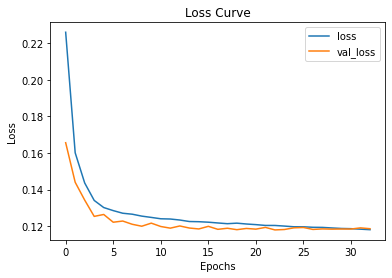

In [9]:
# Loss
import os
os.makedirs("Protein_CNN_Attention_resultImage",exist_ok=True)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()
plt.savefig("Protein_CNN_Attention_resultImage/Loss Curve.png", dpi=600, bbox_inches='tight')
plt.show()


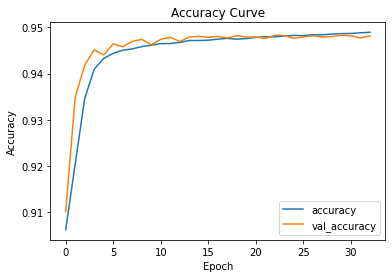

In [10]:
#Accuracy
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig("Protein_CNN_Attention_resultImage/Accuracy Curve.png", dpi=600, bbox_inches='tight')
plt.show()

### Use test data set

36/36 [==============================] - 0s 8ms/step - loss: 0.1206 - accuracy: 0.9468 - precision: 0.9635 - recall: 0.9323
test - loss: 0.1206, accuracy: 0.9468, precision: 0.9635, recall: 0.9323
36/36 [==============================] - 0s 7ms/step


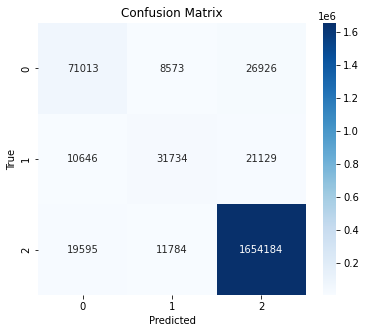

precision_overall: 0.9438
recall_overall: 0.9468
sepcificity_overall: 0.8962
F1_overall: 0.9451
accuracy: 0.9468
ROC-AUC Score: 0.9827


In [11]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.preprocessing import label_binarize
import tensorflow as tf
import seaborn as sns

loss, accuracy, precision, recall = model.evaluate(X_test, y_test)
print(f"test - loss: {loss:.4f}, accuracy: {accuracy:.4f}, precision: {precision:.4f}, recall: {recall:.4f}")


y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=-1).flatten()
y_true = np.argmax(y_test, axis=-1).flatten()


cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2])

plt.figure(figsize=(6, 5)) 
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0,1,2], yticklabels=[0,1,2]) 
plt.xlabel('Predicted')
plt.ylabel('True') 
plt.title('Confusion Matrix')
plt.savefig("Protein_CNN_Attention_resultImage/confusion_matrix.png", dpi=600, bbox_inches='tight')
plt.show()


precision_overall = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall_overall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1_overall = f1_score(y_true, y_pred, average='weighted', zero_division=0)

specificity = []
for i in range(len(cm)):
    TN = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
    FP = np.sum(cm[:, i]) - cm[i, i]
    spec = TN / (TN + FP) if (TN + FP) > 0 else 0
    specificity.append(spec)
specificity_overall = np.mean(specificity)


print(f"precision_overall: {precision_overall:.4f}")
print(f"recall_overall: {recall_overall:.4f}")
print(f"sepcificity_overall: {specificity_overall:.4f}")
print(f"F1_overall: {f1_overall:.4f}")
print(f"accuracy: {accuracy:.4f}")


y_true_binarized = label_binarize(y_true, classes=[0, 1, 2])  
n_classes = y_true_binarized.shape[1]

# Reshape y_pred_probs to match y_true
y_pred_probs_reshaped = y_pred_probs.reshape(-1, n_classes)

# Calculate ROC-AUC for each class
roc_auc = roc_auc_score(y_true_binarized, y_pred_probs_reshaped, multi_class='ovo')
print(f"ROC-AUC Score: {roc_auc:.4f}")

36/36 [==============================] - 0s 7ms/step
ROC-AUC Score: 0.9827


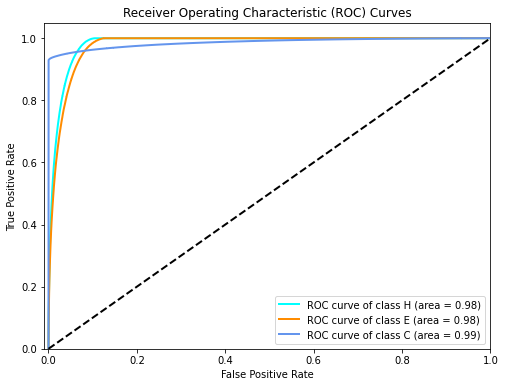

Class H:
  Precision: 0.7013
  Recall (Sensitivity): 0.6667
  Specificity: 0.9827
  F1-Score: 0.6836

Class E:
  Precision: 0.6092
  Recall (Sensitivity): 0.4997
  Specificity: 0.9886
  F1-Score: 0.5490

Class C:
  Precision: 0.9718
  Recall (Sensitivity): 0.9814
  Specificity: 0.7174
  F1-Score: 0.9766

Overall Accuracy: 0.9468


In [12]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Convert one-hot encoded labels and predictions to class labels
y_pred_probs = model.predict(X_test)  
y_pred = np.argmax(y_pred_probs, axis=-1).reshape(-1)  
y_true = np.argmax(y_test, axis=-1).reshape(-1)        

# Verify that y_pred and y_true have the same number of samples
assert y_pred.shape[0] == y_true.shape[0], "y_pred and y_true must have the same number of samples."

# Binarize the true labels for ROC-AUC calculation
y_true_binarized = label_binarize(y_true, classes=[0, 1, 2]) 
n_classes = y_true_binarized.shape[1]

# Reshape y_pred_probs to match y_true
y_pred_probs_reshaped = y_pred_probs.reshape(-1, n_classes)

# Calculate ROC-AUC for each class
roc_auc = roc_auc_score(y_true_binarized, y_pred_probs_reshaped, multi_class='ovo')
print(f"ROC-AUC Score: {roc_auc:.4f}")

# Plot ROC Curves for each class
fpr = dict()
tpr = dict()
roc_auc_dict = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_binarized[:, i], y_pred_probs_reshaped[:, i])
    roc_auc_dict[i] = auc(fpr[i], tpr[i])

# Plotting ROC Curves
plt.figure(figsize=(8, 6))
colors = ['aqua', 'darkorange', 'cornflowerblue']
class_names = ['H', 'E', 'C']  

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc_dict[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.savefig("Protein_CNN_Attention_resultImage/roc_curves.png", dpi=600, bbox_inches='tight') 
plt.show()

# Calculate per-class precision, recall (sensitivity), f1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, y_pred, labels=[0,1,2], zero_division=0)

# Calculate specificity
cm = confusion_matrix(y_true, y_pred, labels=[0,1,2])

specificity = {}
for i, cls in enumerate(class_names):
    TN = np.sum(cm) - (np.sum(cm[i, :]) + np.sum(cm[:, i]) - cm[i, i])
    FP = np.sum(cm[:, i]) - cm[i, i]
    specificity[cls] = TN / (TN + FP) if (TN + FP) > 0 else 0.0

# Calculate overall accuracy
accuracy = accuracy_score(y_true, y_pred)

# Print per-class metrics
for i, cls in enumerate(class_names):
    print(f"Class {cls}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall (Sensitivity): {recall[i]:.4f}")
    print(f"  Specificity: {specificity[cls]:.4f}")
    print(f"  F1-Score: {f1_score[i]:.4f}")
    print()

print(f"Overall Accuracy: {accuracy:.4f}")